In [12]:
import pandas as pd
import kagglehub
from sklearn.linear_model import LinearRegression
from shapely.geometry import Point
import geopandas as gpd
from datetime import timedelta

In [13]:
years = [2021, 2022, 2023, 2024, 2025]
crime_dfs = []

for year in years:
    df = pd.read_csv(f"data/philadelphia_crime_data_{year}.csv")
    df["year"] = year
    df["dispatch_date_time"] = pd.to_datetime(df["dispatch_date_time"])
    df["date"] = df["dispatch_date_time"].dt.date
    crime_dfs.append(df)

philly_crime_all = pd.concat(crime_dfs, ignore_index=True)

In [17]:
# Load ZIP code shapefile 
zip_shapes = gpd.read_file("data/Zipcodes_Poly/Zipcodes_Poly.shp")
#we only care about lat and lng coords
crime_geo = philly_crime_all.dropna(subset=["lat", "lng"]).copy()

# Create geometry points
crime_geo["geometry"] = [Point(xy) for xy in zip(crime_geo["lng"], crime_geo["lat"])]
crime_gdf = gpd.GeoDataFrame(crime_geo, geometry="geometry", crs="EPSG:4326")

#ZIP shapefile is in same CRS
zip_shapes = zip_shapes.to_crs(crime_gdf.crs)

#Spatial join to attach ZIP code
philly_crime_all = gpd.sjoin(crime_gdf, zip_shapes, how="left", predicate="within")

In [19]:
# Ensure 'date' column is in datetime format
philly_crime_all["date"] = pd.to_datetime(philly_crime_all["date"])

# Define key dates
super_bowl_date = pd.to_datetime("2025-02-09")
riots_date = pd.to_datetime("2025-02-10")
one_year_prior = super_bowl_date - pd.Timedelta(days=365)

# Crimes on Super Bowl and Riot Day
super_bowl_crimes = philly_crime_all[philly_crime_all["date"] == super_bowl_date]
riots_crimes = philly_crime_all[philly_crime_all["date"] == riots_date]
num_crimes_super_bowl_day = len(super_bowl_crimes)
num_crimes_riot_day = len(riots_crimes)

# Filter to all days in prior year (excluding Super Bowl and Riot Day)
prior_year_crimes = philly_crime_all[
    (philly_crime_all["date"] >= one_year_prior) &
    (philly_crime_all["date"] < super_bowl_date)
]

# Compute average crimes per day
daily_crime_counts = prior_year_crimes.groupby("date").size()
avg_crimes_per_day = daily_crime_counts.mean()

# Compute deltas
delta_super_bowl = num_crimes_super_bowl_day - avg_crimes_per_day
delta_riot_day = num_crimes_riot_day - avg_crimes_per_day

# Output results
print(f"Crimes on Super Bowl Sunday (Feb 9, 2025): {num_crimes_super_bowl_day}")
print(f"Crimes on Riot Day (Feb 10, 2025): {num_crimes_riot_day}")
print(f"Average daily crimes in prior year: {avg_crimes_per_day:.2f}")
print(f"Δ crime (Super Bowl day - average): {delta_super_bowl:.2f}")
print(f"Δ crime (Riot day - average): {delta_riot_day:.2f}")


Crimes on Super Bowl Sunday (Feb 9, 2025): 266
Crimes on Riot Day (Feb 10, 2025): 458
Average daily crimes in prior year: 419.15
Δ crime (Super Bowl day - average): -153.15
Δ crime (Riot day - average): 38.85


/var/folders/xt/d01l_q856c9g34hfhlqrwxch0000gn/T/ipykernel_10092/1940661671.py:19: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


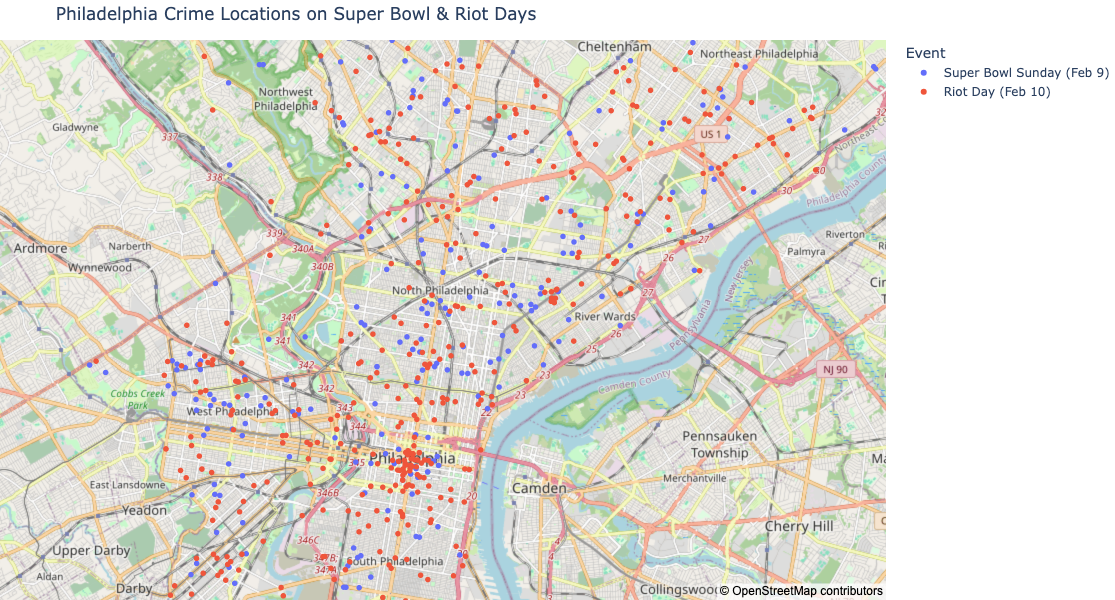

In [27]:
import plotly.express as px

# Ensure coordinates are numeric
philly_crime_all["lat"] = pd.to_numeric(philly_crime_all["lat"], errors="coerce")
philly_crime_all["lng"] = pd.to_numeric(philly_crime_all["lng"], errors="coerce")

# Drop rows with missing coordinates
super_bowl_crimes = super_bowl_crimes.dropna(subset=["lat", "lng"]).copy()
riots_crimes = riots_crimes.dropna(subset=["lat", "lng"]).copy()

# Label the events
super_bowl_crimes["Event"] = "Super Bowl Sunday (Feb 9)"
riots_crimes["Event"] = "Riot Day (Feb 10)"

# Combine datasets
combined = pd.concat([super_bowl_crimes, riots_crimes], axis=0)

# Plot map
fig = px.scatter_mapbox(
    combined,
    lat="lat",
    lon="lng",
    color="Event",
    hover_name="Primary Type" if "Primary Type" in combined.columns else None,
    hover_data=["date"] if "date" in combined.columns else None,
    zoom=11,
    height=600,
    title="Philadelphia Crime Locations on Super Bowl & Riot Days",
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0, "t":40, "l":0, "b":0})
fig.show()
